In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler


In [57]:
def add_features(X):
    X = X.copy()
    
    # Week-of-month categorical
    X["week_of_month"] = pd.cut(
        X["day"],
        bins=[0, 7, 14, 21, np.inf],
        labels=["week1", "week2", "week3", "week4"]
    )
    
    # Years since start numeric
    X["years_since_start"] = X["year"] - X["year"].min()
    
    return X


In [58]:
df=pd.read_csv("data/processed_Data.csv").dropna(how='any',axis=0).reset_index(drop=True)



In [59]:
label_attrib=["price"]
raw_attrib=["day"]
strata="year"
cat_attribs=["month","week_of_month"]
num_features=["years_since_start"]

In [60]:
def stratifiedshufflesplitter(df, bins, strata_col, test_size):
    """
    Performs stratified shuffle split based on income bins of median income value
    """
    df = df.copy()
    strata_cat = "__strata__"
    df[strata_cat] = pd.qcut(df[strata_col], q=bins, labels=False,    duplicates="drop")

    split = StratifiedShuffleSplit(
        n_splits=1,
        test_size=test_size,
        random_state=24
    )

    for train_idx, test_idx in split.split(df, df[strata_cat]):
        train = df.loc[train_idx].drop(strata_cat, axis=1)
        test = df.loc[test_idx].drop(strata_cat, axis=1)

    return train, test


In [61]:
train,test= stratifiedshufflesplitter(df,10,strata,0.2) 

In [62]:
feature_adder = FunctionTransformer(add_features)
cat_pipeline=Pipeline([
    ("encoding",OneHotEncoder(handle_unknown="ignore"))
])

full_pipeline = Pipeline([
    ("feature_adder", feature_adder),  # add engineered features
    ("preprocessor", ColumnTransformer([
        ("cat", cat_pipeline, cat_attribs)
    ]))
])

In [63]:
X=full_pipeline.fit_transform(train)
cat_encoder = full_pipeline.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoding"]
cat_encoded_attribs = cat_encoder.get_feature_names_out(cat_attribs)
num_encoded_attribs = list(num_features) + list(cat_encoded_attribs)
X_prepared=pd.DataFrame(X.toarray(),columns=num_encoded_attribs,index=train.index)
X_prepared

ValueError: Shape of passed values is (1963, 16), indices imply (1963, 17)

In [ ]:
forest_reg=RandomForestRegressor()
y_train=train[label_attrib]
forest_reg.fit(X_prepared, y_train)

c:\Programs\anaconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [ ]:
transformed_test=full_pipeline.fit_transform(test)
cat_encoder = full_pipeline.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoding"]
cat_encoded_attribs = cat_encoder.get_feature_names_out(cat_attribs)
num_encoded_attribs = list(num_features) + list(cat_encoded_attribs)
test_prepared=pd.DataFrame(transformed_test.toarray(),columns=num_encoded_attribs,index=test.index)
test_labels=test[label_attrib]
test_labels

ValueError: Shape of passed values is (491, 16), indices imply (491, 17)

,years_since_start,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,week_of_month_week1,week_of_month_week2,week_of_month_week3,week_of_month_week4
1919,-0.714286,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1783,-0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1771,-0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
14,0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
429,0.428571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,-0.428571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
246,0.714286,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
426,0.428571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1239,-0.142857,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
forest_preds = forest_reg.predict(test_prepared)
forest_preds

array([ 800.19351407, 1050.28036905, 1042.35437114, 3824.58295256,
       1575.09672315, 1587.28121825, 1895.53113889, 1731.63559325,
        751.59180689, 1238.31408333, 1175.45733684, 1143.68110714,
       1113.09381944,  990.55630952, 1093.06501605, 2625.42032526,
       1188.59169841, 1107.91304182, 1638.12386665, 1580.09737861,
        727.56882143,  716.41095513, 1088.09133712, 1216.74310317,
       1718.55929618,  646.59284524, 1207.52290079, 1296.75560913,
       1163.83257143,  664.0027405 , 1197.75342617,  617.5       ,
       1095.69012897, 1170.66821627,  617.5       ,  808.44396771,
       1163.83257143,  990.55630952,  995.80550104, 1152.31581205,
       1161.21886706, 2694.31893957, 1188.65374782, 1113.09381944,
       1594.50056349,  800.19351407, 1165.18709325, 1237.5203566 ,
       1174.2135878 , 1095.69012897, 1682.05283532,  836.42208333,
       1161.21886706, 1143.68110714, 1056.00015981, 1216.19170833,
       2013.05620933, 1071.91134891, 1039.46641275, 1482.53011

In [ ]:
results = pd.DataFrame({
    "Actual": test_labels.squeeze(),
    "Predicted": forest_preds.ravel()
})
results["Predicted"]

1919     800.193514
1783    1050.280369
1771    1042.354371
14      3824.582953
429     1575.096723
           ...     
1382    1063.520453
246     1731.635593
426     1575.096723
1239    1084.793135
490     1557.116832
Name: Predicted, Length: 491, dtype: float64

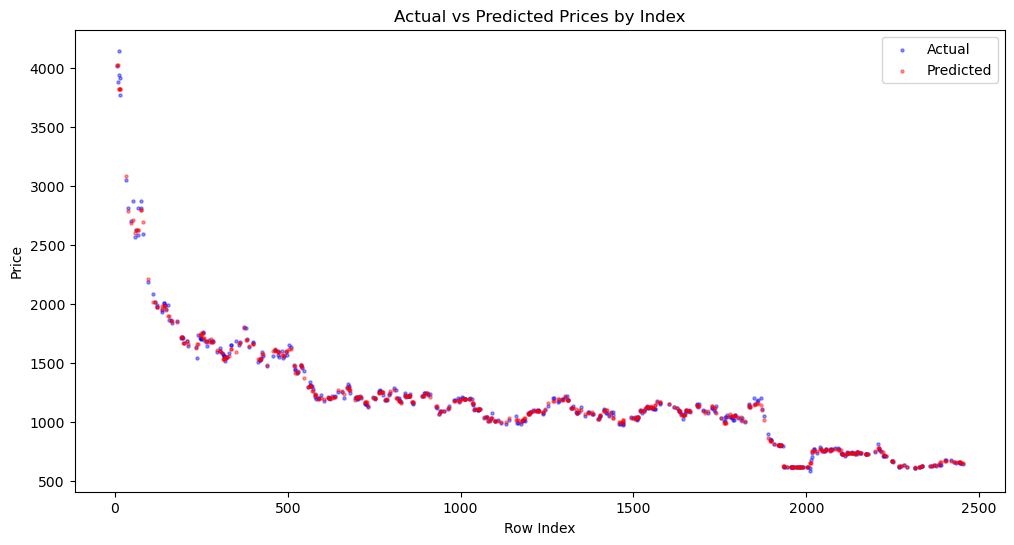

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot Actual prices
plt.scatter(test.index, results["Actual"], color='blue',s=5, alpha=0.4, label="Actual")

# Plot Predicted prices
plt.scatter(test.index, results["Predicted"], color='red',s=5, alpha=0.4, label="Predicted")

plt.xlabel("Row Index")
plt.ylabel("Price")
plt.title("Actual vs Predicted Prices by Index")
plt.legend()
plt.show()


In [64]:
test["Predicted"]=results["Predicted"]
test

,year,month,day,price,Predicted
1919,2020,6,20,797.5,800.193514
1783,2020,11,5,1037.5,1050.280369
1771,2020,11,18,1054.5,1042.354371
14,2025,12,26,3914.0,3824.582953
429,2024,8,23,1556.0,1575.096723
...,...,...,...,...,...
1382,2021,12,20,1067.5,1063.520453
246,2025,3,26,1706.0,1731.635593
426,2024,8,27,1586.0,1575.096723
1239,2022,5,13,1071.5,1084.793135
